# Advanced Lane Finding 

In [64]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Step 1: Distortion Correction

Firstly I will use cv2.findChessboardCorners() and cv2.drawChessboardCorners() to find and draw the inside corners in those chessboards.

In [165]:
CAL_IMGS_PATH = 'camera_cal/calibration*.jpg'
TEST_IMGS_PATH = 'test_images/test*.jpg'

class Calibration:
    perspective_src = np.float32([[490, 482],[810, 482],
                                  [1250, 720],[40, 720]])
    perspective_dst = np.float32([[0, 0], [1280, 0], 
                                  [1250, 720],[40, 720]])

    
    def __init__(self, nx, ny):
        # nx represent the number of inside corners in x axis
        # ny represent the number of inside corners in y axis
        self.nx, self.ny = nx, ny
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane
        self.cal_imgs = []
        self.cal_imgs_with_corners = []
        self.test_imgs = []
        self.test_imgs_with_undistorted = []
        self.test_imgs_with_birdseye = []

    def load_cal_imgs(self, cal_path):
        cal_img_names = glob.glob(cal_path)
        self.cal_imgs = [cv2.imread(name) for name in cal_img_names]

    def load_test_imgs(self, test_path):
        test_img_names = glob.glob(test_path)
        self.test_imgs = [cv2.imread(name) for name in test_img_names]

    def draw_corners(self):
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        for img in self.cal_imgs:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            # If found, draw corners
            if ret == True:
                orig_img = img.copy()
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw the corners
                cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                self.cal_imgs_with_corners.append(((orig_img, img)))
   
    def undistort(self):
        for img in self.test_imgs:
            img_size = (img.shape[1], img.shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
            undist = cv2.undistort(img, mtx, dist, None, mtx)
            self.test_imgs_with_undistorted.append((img, undist))
            
    def birds_eye(self):
        for orig_img, undist_img in self.test_imgs_with_undistorted:
            # Grab the image shape
            img_size = (orig_img.shape[1], orig_img.shape[0])
            # Given src and dst points, calculate the perspective transform matrix
            M = cv2.getPerspectiveTransform(self.perspective_src, self.perspective_dst)
            # Warp the image using OpenCV warpPerspective()
            warped = cv2.warpPerspective(undist_img, M, img_size)
            self.test_imgs_with_birdseye.append((orig_img, warped))


    def combined_binary(self):
        combined_binary_lst = []
        for _, img in self.test_imgs_with_birdseye:
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

            b_thresh_min = 155
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
            
            l_thresh_min = 225
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            combined_binary_lst.append(combined_binary)
        
        return combined_binary_lst

    def fill_lane(self):
        combined_binary = self.combined_binary()[2]
        
        rightx = []
        righty = []
        leftx = []
        lefty = []
        
        x, y = np.nonzero(np.transpose(combined_binary))
        i = 720
        j = 630
        while j >= 0:
            histogram = np.sum(combined_binary[j:i,:], axis=0)
            left_peak = np.argmax(histogram[:640])
            x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                leftx.extend(x_window.tolist())
                lefty.extend(y_window.tolist())

            right_peak = np.argmax(histogram[640:]) + 640
            x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                rightx.extend(x_window.tolist())
                righty.extend(y_window.tolist())
            i -= 90
            j -= 90

        lefty = np.array(lefty).astype(np.float32)
        leftx = np.array(leftx).astype(np.float32)
        righty = np.array(righty).astype(np.float32)
        rightx = np.array(rightx).astype(np.float32)
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
        rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
        rightx = np.append(rightx,rightx_int)
        righty = np.append(righty, 720)
        rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
        righty = np.append(righty, 0)
        leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
        leftx = np.append(leftx, leftx_int)
        lefty = np.append(lefty, 720)
        leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
        lefty = np.append(lefty, 0)
        lsort = np.argsort(lefty)
        rsort = np.argsort(righty)
        lefty = lefty[lsort]
        leftx = leftx[lsort]
        righty = righty[rsort]
        rightx = rightx[rsort]
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
        
        # Measure Radius of Curvature for each lane line
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
    
    
        # Calculate the position of the vehicle
        center = abs(640 - ((rightx_int+leftx_int)/2))
        
        offset = 0 
        img_size = (img.shape[1], img.shape[0])
        src = np.float32([[490, 482],[810, 482],
                        [1250, 720],[40, 720]])
        dst = np.float32([[0, 0], [1280, 0], 
                        [1250, 720],[40, 720]])
        Minv = cv2.getPerspectiveTransform(dst, src)
        
        warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
        pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
        pts = np.hstack((pts_left, pts_right))
        cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
        result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
        
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fitx, lefty, color='green', linewidth=3)
        ax1.plot(right_fitx, righty, color='green', linewidth=3)
        ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images
        ax2.imshow(result)
        ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
        if center < 640:
            ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                    style='italic', color='white', fontsize=10)
        else:
            ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                    style='italic', color='white', fontsize=10)
        ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
                style='italic', color='white', fontsize=10)

    def show_cal_plot(self):
        for orig_img, img in self.cal_imgs_with_corners:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(orig_img)
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(img)
            ax2.set_title('Image With Corners', fontsize=18)
            
    def show_test_plot(self):
        for orig_img, img in self.test_imgs_with_undistorted:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Undistorted Image', fontsize=18)
            
    def show_birdseye_plot(self):
        for orig_img, img in self.test_imgs_with_birdseye:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Warped Image', fontsize=18)
            

    def show_threshold_plot(self):
     
        for _, img in self.test_imgs_with_birdseye:
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

#             # Red channel
#             thresh = (200, 255)
#             red = img[:, :, 0]
#             r_channel = np.zeros_like(red)
#             r_channel[(red > thresh[0]) & (red <= thresh[1])] = 1
    
            b_thresh_min = 155
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
            
            l_thresh_min = 225
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            # Plotting thresholded images
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(10,6))
            f.tight_layout()
            
            ax1.set_title('Warped Image', fontsize=16)
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

            ax2.set_title('b binary threshold', fontsize=16)
            ax2.imshow(b_binary, cmap='gray')
            
            ax3.set_title('l binary threshold', fontsize=16)
            ax3.imshow(l_binary, cmap='gray')

            ax4.set_title('Combined color thresholds', fontsize=16)
            ax4.imshow(combined_binary, cmap='gray')

In [166]:
# find and draw the inside corner of the chessboards 
cal = Calibration(9, 6)
cal.load_cal_imgs(CAL_IMGS_PATH)
cal.draw_corners()
# cal.show_cal_plot()

Next I will use undistort() to calculate camera calibration matrix and distortion coefficients. It can remove distortion of image and output the undistorted image.

In [167]:
# undistort the test images
cal.load_test_imgs(TEST_IMGS_PATH)
cal.undistort()
# cal.show_test_plot()


## Step 2: Perspective Transform

In [168]:
cal.birds_eye()
#cal.show_birdseye_plot()

## Step 3: Apply Binary Thresholds

In [169]:
#cal.show_threshold_plot()

## Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

NameError: name 'birds_eye' is not defined

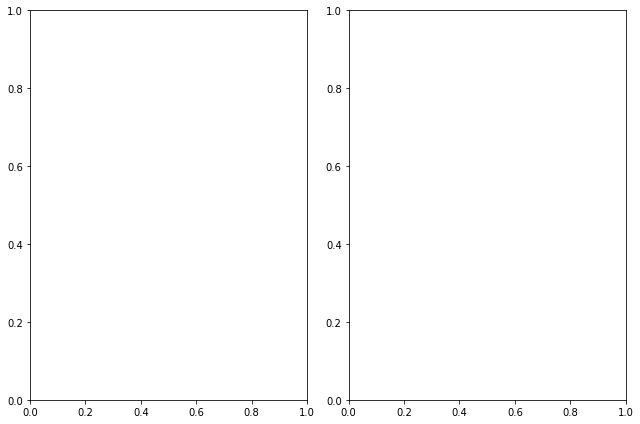

In [170]:
cal.fill_lane()